In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from elfpy.simulators import YieldSimulator
from elfpy.utils.data import format_trades

In [2]:
# make folder if it doesn't exit
out_dir = os.path.join(os.pardir, 'outputs')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [3]:
pd.set_option("float_format",'{:,.6f}'.format)

random_seed = 3
simulator_rng = np.random.default_rng(random_seed)
config = {
    "min_fee": 0.1, # decimal that assigns fee_percent
    "max_fee": 0.5, # decimal that assigns fee_percent
    "min_target_liquidity": 1e6, # in USD
    "max_target_liquidity": 10e6, # in USD
    "min_target_volume": 0.001, # fraction of pool liquidity
    "max_target_volume": 0.01, # fration of pool liquidity
    "min_pool_apy": 0.02, # as a decimal
    "max_pool_apy": 0.9, # as a decimal
    "min_vault_age": 0, # fraction of a year
    "max_vault_age": 1, # fraction of a year
    "min_vault_apy": 0.001, # as a decimal
    "max_vault_apy": 0.9, # as a decimal
    "base_asset_price": 2.5e3, # aka market price
    "pool_duration": 180, # in days
    "num_trading_days": 180, # should be <= pool_duration
    "floor_fee": 0, # minimum fee percentage (bps)
    "tokens": ["base", "fyt"],
    "trade_direction": "out",
    "precision": None,
    "pricing_model_name": "Element",
    "user_type": "Random",
    "rng": simulator_rng,
    "verbose": False,
}

In [4]:
start_time = time.time()
num_runs = 0

simulator = YieldSimulator(**config)
simulator.set_random_variables()

apy = [0.10]*config['num_trading_days']
#apy[config['num_trading_days']//2:(config['num_trading_days']//2) + 5] == [0.08, 0.08, 0.08]
#apy[config['num_trading_days']//2:] = [0.08,]*(config['num_trading_days']//2)
# apy[config['num_trading_days']//2:] = [0.01,]*(config['num_trading_days']//2)
# apy[config['num_trading_days']//2:] = [-0.2,]*(config['num_trading_days']//2)

override_dict = {
    'pricing_model_name': 'Element',
    'vault_apy': apy,
    'init_pool_apy' : apy[0],
    'init_vault_age': 1,
    'target_daily_volume': 5*1e5,
    'target_liquidity': 10*1e6,
    'fee_percent' : 0.1,
}
simulator.reset_rng(np.random.default_rng(random_seed)) # do this to make sure simulations run over the same trade sequence
simulator.run_simulation(override_dict)
num_runs += 1

floor_fee_list = [0, 10] # bps
override_dict['pricing_model_name'] = 'YieldSpacev2'
for floor_fee in floor_fee_list:
    override_dict['floor_fee'] = floor_fee
    simulator.reset_rng(np.random.default_rng(random_seed)) # do this to make sure simulations run over the same trade sequence
    simulator.run_simulation(override_dict)
    num_runs += 1

end_time = time.time()
print(f'Total time for {num_runs} runs was {end_time-start_time:.3f} seconds; which is {(end_time-start_time)/num_runs:.3f} seconds per run')

Total time for 3 runs was 0.075 seconds; which is 0.025 seconds per run


In [5]:
[trades, trades_agg] = format_trades(simulator.analysis_dict)

In [6]:
display(trades.groupby(['model_name', 'token_in']).agg({
    'trade_volume_usd': ['sum'],
    'run_trade_number': ['count'],
    'fee_in_bps': ['mean', 'std', 'min', 'max', 'sum'],
    'day': ['mean', 'min', 'max'],
    })
)

trade_volume_usd run_trade_number fee_in_bps  \
                                          sum            count       mean   
model_name         token_in                                                 
Element            base     48,644,282.828373              953  18.567311   
                   fyt      45,970,410.762656              941  19.061796   
YieldSpacev2       base     48,659,074.062124              953  18.898722   
                   fyt      45,953,342.465249              941  19.403199   
YieldSpacev2MinFee base     48,651,975.197077              953  20.391302   
                   fyt      45,946,289.508524              941  20.919682   

                                                                         \
                                  std       min       max           sum   
model_name         token_in                                               
Element            base     13.937334  0.151891 51.955831 17,694.647063   
                   fyt      14.848894  0.145905 54.843215 17,937.149831   
YieldSpacev2       base     13.902247  0.162858 52.021894 18,010.482426   
                   fyt      14.810746  0.156882 54.916749 18,258.410388   
YieldSpacev2MinFee base     12.420831  9.901168 52.021894 19,432.911155   
                   fyt      13.350840 10.001568 54.916749 19,685.421169   

                                  day           
                                 mean min  max  
model_name         token_in                     
Element            base     89.251836   0  179  
                   fyt      89.781084   0  179  
YieldSpacev2       base     89.251836   0  179  
                   fyt      89.781084   0  179  
YieldSpacev2MinFee base     89.251836   0  179  
                   fyt      89.781084   0  179

Figure saved to ../outputs/fees_constant_vault_apy.png


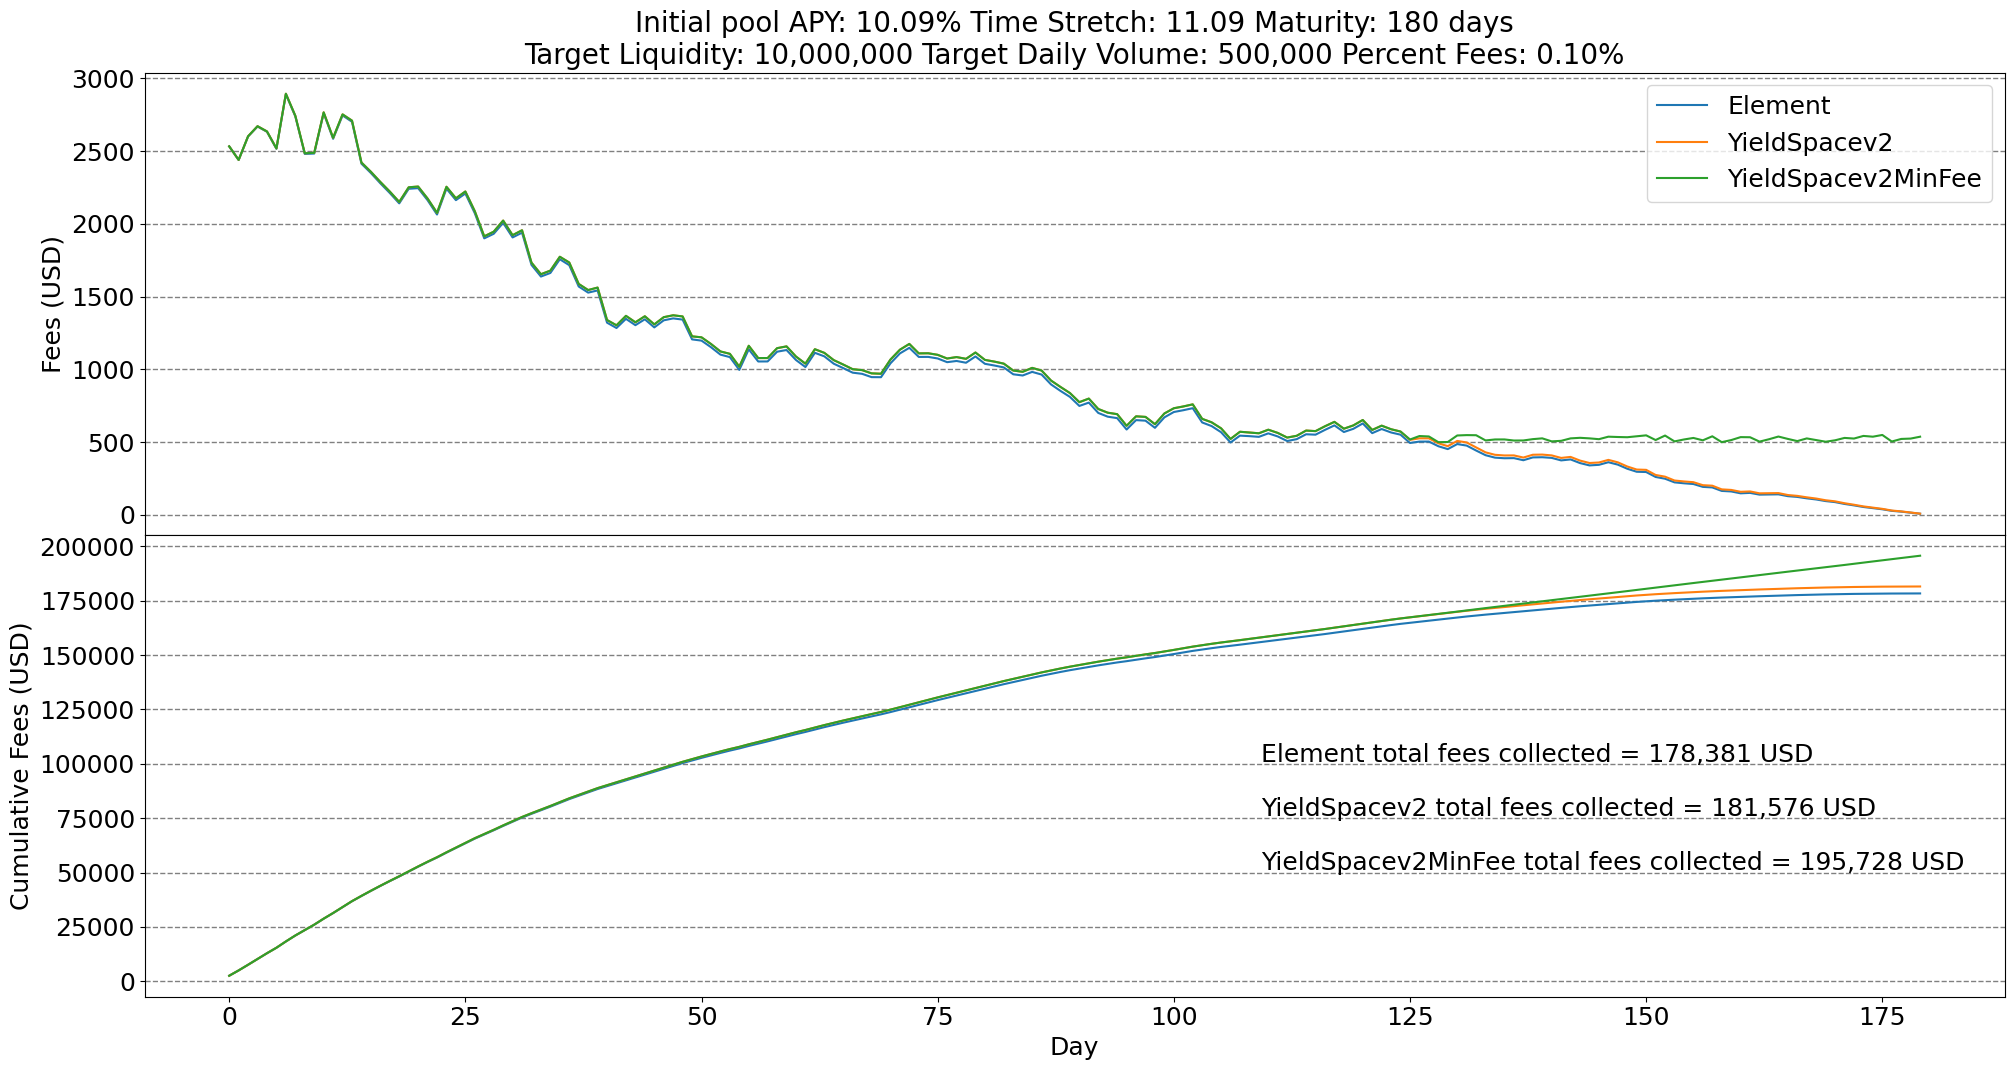

In [7]:
num_plots = 2
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])
model_colors = {model:colors[i] for i, model in enumerate(trades_agg.model_name.unique())}

## DAY PLOTS
figsize = (24, 12)
fig, ax = plt.subplots(
    ncols=1,
    nrows=num_plots,
    gridspec_kw={'wspace':0, 'hspace':0, 'height_ratios':np.ones(num_plots)}
)
fig.patch.set_facecolor('white')   # set fig background color to white

# fees
current_plot = 0
for model in trades_agg.model_name.unique():
    model_df = trades_agg.loc[trades_agg.model_name==model, :]
    ax[current_plot] = model_df.plot(
        x='day',
        y='fee_in_usd_sum',
        figsize=figsize,
        ax=ax[current_plot],
        color=model_colors[model],
        label=model
    )
ax[current_plot].set_xlabel('')
ax[current_plot].set_ylabel('Fees (USD)', fontsize=18)
ax[current_plot].tick_params(axis='both', labelsize=18)
ax[current_plot].grid(
    visible=True, linestyle='--', linewidth='1', color='grey', which='both', axis='y'
)
ax[current_plot].xaxis.set_ticklabels([])
title = (
    f'Initial pool APY: {trades.pool_apy[0]*100:.2f}% '
    + f'Time Stretch: {trades.init_time_stretch[0]:.2f} '
    + f'Maturity: {trades.pool_duration[0]} days\n'
    + f'Target Liquidity: {trades.target_liquidity[0]:,.0f} '
    + f'Target Daily Volume: {trades.target_daily_volume[0]:,.0f} '
    + f'Percent Fees: {trades.fee_percent[0]:.2f}%'
)
ax[current_plot].set_title(title, fontsize=20)
ax[current_plot].legend(fontsize=18)

# fees cumulative
current_plot += 1
for model_idx, model in enumerate(trades_agg.model_name.unique()):
    model_df = trades_agg.loc[trades_agg.model_name==model, :]
    #cumulative_fee = model_df.fee_in_usd_cum_sum.iloc[-1]
    ax[current_plot] = model_df.plot(
        x='day',
        y='fee_in_usd_cum_sum',
        figsize=figsize,
        ax=ax[current_plot],
        color=model_colors[model],
        legend=None,
    )
    xlim = ax[current_plot].get_xlim()
    total_fees = model_df.fee_in_usd_cum_sum.iloc[-1]
    ax[current_plot].annotate(
        f'{model} total fees collected = {total_fees:,.0f} USD',
        (xlim[0] + (xlim[1]-xlim[0])*0.6,
        1.01e5-2.5e4*model_idx),
        fontsize=18
    )
ax[current_plot].set_ylabel('Cumulative Fees (USD)', fontsize=18)
ax[current_plot].tick_params(axis='both', labelsize=18)
ax[current_plot].grid(
    visible=True,
    linestyle='--',
    linewidth='1',
    color='grey',
    which='both',
    axis='y',
)
ax[current_plot].set_xlabel('Day', fontsize=18)

if apy[0] == apy[-1]:
    fig.savefig(os.path.join(out_dir, 'fees_constant_vault_apy.png'),bbox_inches='tight')
    print(f'Figure saved to {os.path.join(out_dir, "fees_constant_vault_apy.png")}')
else:
    fig.savefig(os.path.join(out_dir, 'fees_variable_vault_apy.png'),bbox_inches='tight')
    print(f'Figure saved to {os.path.join(out_dir, "fees_variable_vault_apy.png")}')

/Users/dylan/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:808: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x127e3b340> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/dylan/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:808: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x127e6ad00> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)


Figure saved to  ../outputs/pricing_constant_vault_apy.png


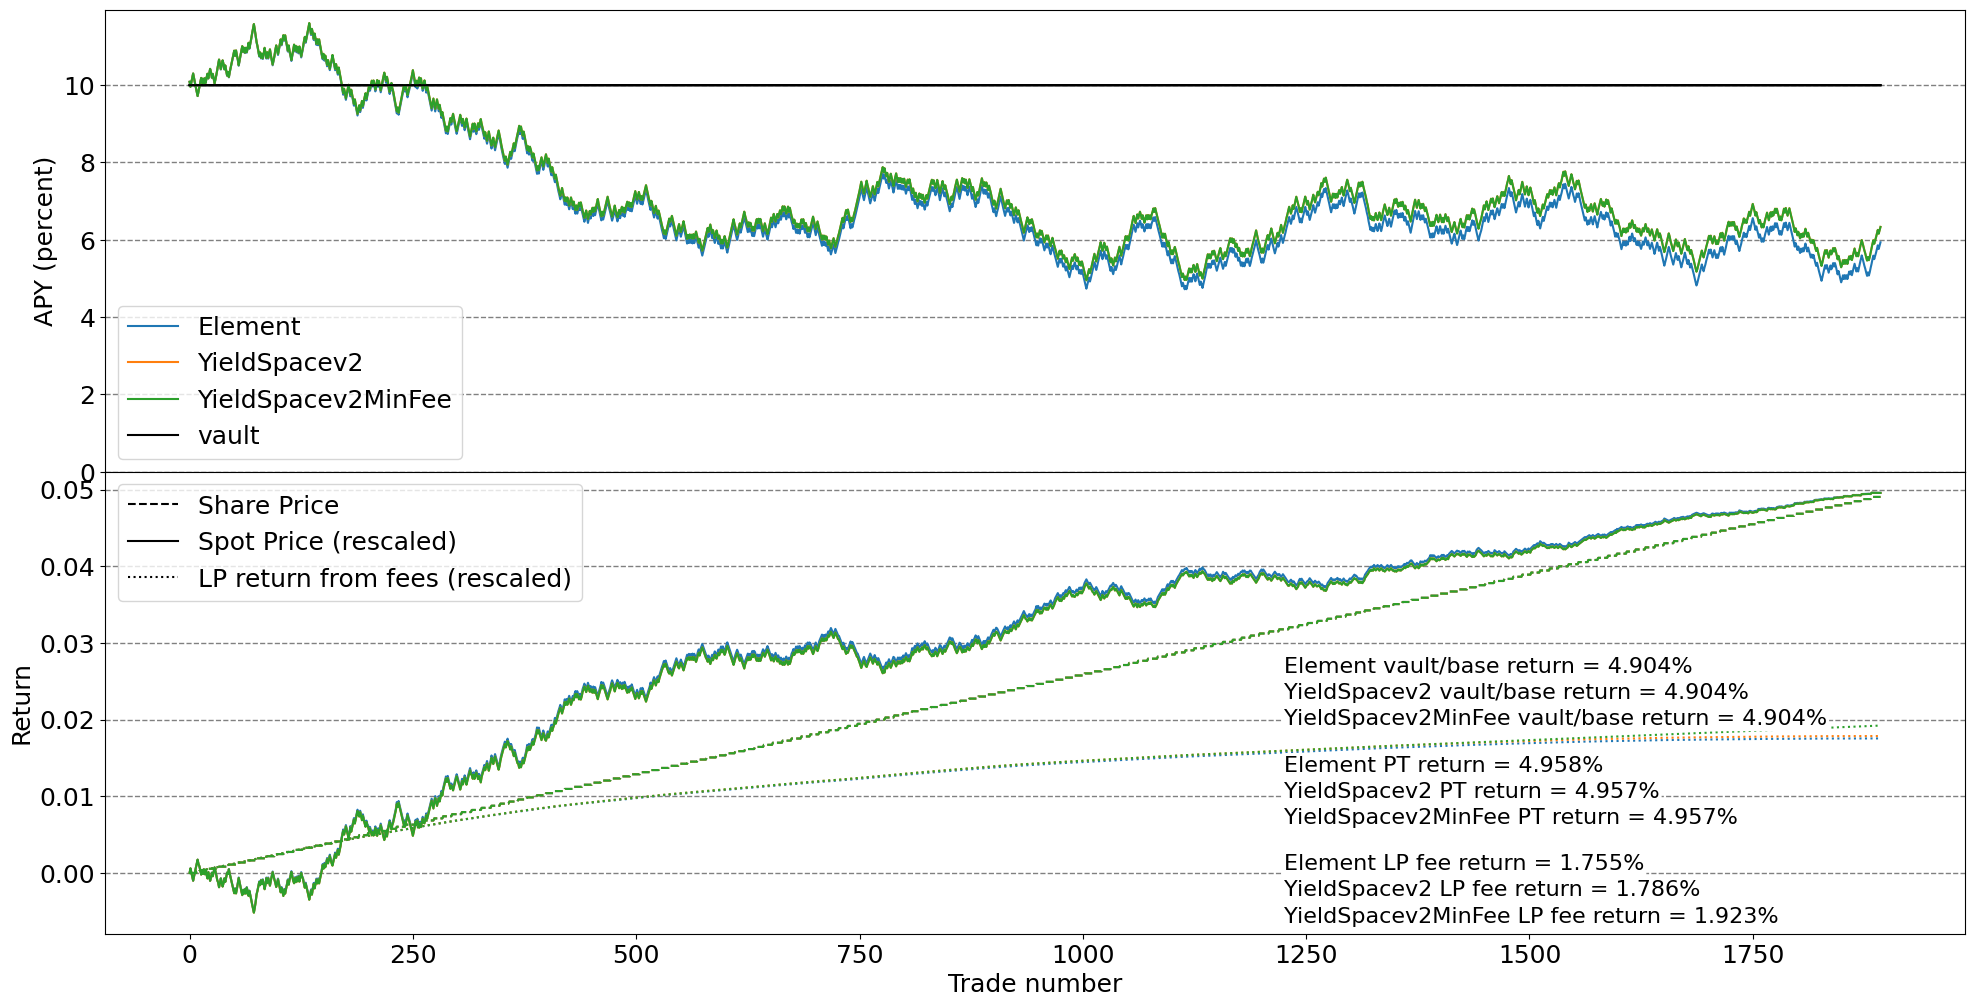

In [8]:
## TRADE PLOTS
num_plots = 2
figsize = (24, 6*num_plots)
fig, ax = plt.subplots(
    ncols=1,
    nrows=num_plots,
    gridspec_kw={'wspace':0, 'hspace':0, 'height_ratios':np.ones(num_plots)}
)
fig.patch.set_facecolor('white')   # set fig background color to white

# pool & vault APYs
current_plot = 0
for model_idx, model in enumerate(trades.model_name.unique()): # for each model (per run?)
    model_df = trades.loc[trades.model_name==model, :]
    ax[current_plot] = model_df.plot(
        x='run_trade_number', # could also do num_orders if you want to know the apy for a given volume of trade
        y='pool_apy_percent',
        figsize=figsize,
        ax=ax[current_plot],
        color=model_colors[model],
        label=f'{model}'
    )
    if model_idx == len(trades.model_name.unique()) - 1:
        label = 'vault'
    else:
        label = '_nolegend_'
    ax[current_plot] = model_df.plot(
        x='run_trade_number',
        y='vault_apy_percent',
        figsize=figsize,
        ax=ax[current_plot],
        linestyle='-',
        color='black',
        label=label,
    )

ax[current_plot].set_xlabel('')
ax[current_plot].set_ylabel('APY (percent)', fontsize=18)
if ax[current_plot].get_ylim()[0] > 0:
    ax[current_plot].set_ylim(0, ax[current_plot].get_ylim()[1]) # set y axis to start at 0 if it's positive
ax[current_plot].tick_params(axis='both', labelsize=18)
ax[current_plot].grid(
    visible=True,
    linestyle='--',
    linewidth='1',
    color='grey',
    which='both',
    axis='y'
)
ax[current_plot].xaxis.set_ticklabels([])
ax[current_plot].legend(fontsize=18)

### price per share & spot price ###
current_plot += 1
annotate_major_offset = 0.098
annotate_minor_offset = 0.026
annotate_position_y = 0.43 # how far up the y axis to put the annotation
annotate_position_x = 0.65 # how far down the x axis to put the annotation
annotate_font_size = 16
annotate_alpha = 1
def annotate(ax,text,major_offset,minor_offset):
    t=ax.annotate(
        text,
        xy=(annotate_position_x, annotate_position_y-annotate_major_offset*major_offset-annotate_minor_offset*minor_offset),
        xytext=(annotate_position_x, annotate_position_y-annotate_major_offset*major_offset-annotate_minor_offset*minor_offset),
        xycoords='subfigure fraction',
        # arrowprops=dict(arrowstyle='->'),
        fontsize=annotate_font_size,
        alpha=annotate_alpha
    )
    t.set_bbox(dict(facecolor='white', edgecolor='black', alpha=annotate_alpha, linewidth=0, boxstyle='round,pad=0.1'))

for model_idx, model in enumerate(trades.model_name.unique()):
    model_df = trades.loc[trades.model_name==model, :]

    ### VAULT/BASE PROFIT ###
    share_price_growth = (
        model_df.loc[:, "share_price_total_return"].values[-1]
    )
    ax[current_plot] = model_df.plot(
        x='run_trade_number',
        y='share_price_total_return',
        figsize=figsize,
        ax=ax[current_plot],
        kind='line',
        style='--',
        color=model_colors[model],
        label='Share Price'
    )

    ### PT PROFIT ###
    spot_price_growth = (
        model_df.loc[:, "price_total_return"].values[-1]
    )
    ax[current_plot] = model_df.plot(
        x='run_trade_number',
        y='price_total_return',
        figsize=figsize,
        ax=ax[current_plot],
        kind='line',
        color=model_colors[model],
        label='Spot Price (rescaled)'
    )

    ### LP PROFIT ###
    lp_fee_price_growth = (
        model_df.loc[:, "lp_total_return"].values[-1]
    )
    ax[current_plot] = model_df.plot(
        x='run_trade_number',
        y='lp_total_return',
        figsize=figsize,
        ax=ax[current_plot],
        kind='line',
        style=':',
        color=model_colors[model],
        label='LP return from fees (rescaled)'
    )

    ### ANNOTATE ###
    annotate(ax[current_plot], f'{model} vault/base return = {share_price_growth:.3%}', 1, model_idx)
    annotate(ax[current_plot], f'{model} PT return = {spot_price_growth:.3%}',          2, model_idx)
    annotate(ax[current_plot], f'{model} LP fee return = {lp_fee_price_growth:.3%}',    3, model_idx)

ax[current_plot].set_ylabel('Return', fontsize=18)
ax[current_plot].tick_params(axis='both', labelsize=18)
ax[current_plot].grid(
    visible=True,
    linestyle='--',
    linewidth='1',
    color='grey',
    which='both',
    axis='y'
)
ax[current_plot].set_xlabel('Trade number', fontsize=18)
handles,lines = ax[current_plot].get_legend_handles_labels()
leg = ax[current_plot].legend([lines[0], lines[1], lines[2]], fontsize=18)
for l in leg.legendHandles: l.set_color('black')

if apy[0] == apy[-1]:
    fig.savefig(os.path.join(out_dir, 'pricing_constant_vault_apy.png'),bbox_inches='tight')
    print(f'Figure saved to  {os.path.join(out_dir, "pricing_constant_vault_apy.png")}')
else:
    fig.savefig(os.path.join(out_dir, 'pricing_variable_vault_apy.png'),bbox_inches='tight')
    print(f'Figure saved to  {os.path.join(out_dir, "pricing_variable_vault_apy.png")}')

plt.show()

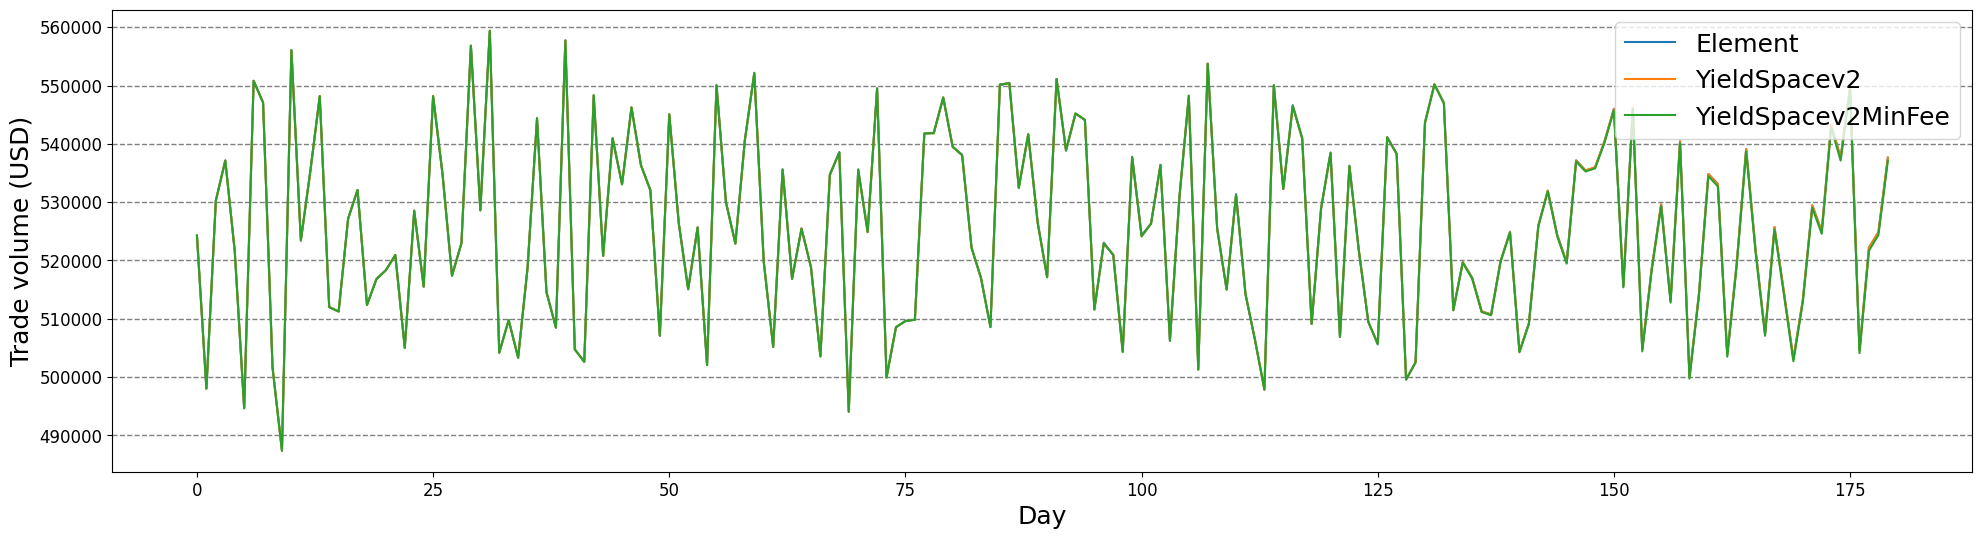

In [9]:
fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot()
for model in trades_agg.model_name.unique():
    model_df = trades_agg.loc[trades_agg.model_name==model, :]
    ax = model_df.plot(
        x='day',
        y='trade_volume_usd_sum',
        kind='line',
        ax=ax,
        color=model_colors[model],
        label=model
    )
ax.set_xlabel('Day', fontsize=18)
ax.set_ylabel('Trade volume (USD)', fontsize=18)
ax.tick_params(axis='both', labelsize=12)
ax.grid(
    visible=True,
    linestyle='--',
    linewidth='1',
    color='grey',
    which='both',
    axis='y'
)
ax.ticklabel_format(style='plain', axis='y')
lh = ax.legend(fontsize=18)
fig.savefig(os.path.join(out_dir, 'trade_volume.png'))